# Coursework title

other things

**Instructions to run this notebook:**

In [4]:
import pandas as pd
import numpy as np

In [5]:
# Set options to display all rows
pd.set_option("display.max_rows", None)


# Reset display options to default
#pd.reset_option("display.max_rows")

## 4.2. Cleaning the data

In [6]:
# Dropbox file links
us_url = "https://www.dropbox.com/scl/fi/7ujbvy5zhj9pcucnhvtrf/International_Financial_Statistics_-1.xlsx?rlkey=i0n7b9tr80217mpb760el0xtq&st=t0rba6sd&dl=1"
france_url = "https://www.dropbox.com/scl/fi/rtr775j5hclqa6an6vzmm/International_Financial_Statistics_.xlsx?rlkey=9ukpgmoemq07cfucg3f11drow&st=2gj4w8th&dl=1"


# Read the Excel files without headers
usdf = pd.read_excel(us_url, header=1)
frdf = pd.read_excel(france_url, header=1)


# Set the second column (Indicators) as index, remove the first column (Country name)
usdf = usdf.set_index(usdf.columns[1]).drop(columns=usdf.columns[0])
frdf = frdf.set_index(frdf.columns[1]).drop(columns=frdf.columns[0])


usdf = usdf.T
frdf = frdf.T


# Convert index to datetime to maintain chronological order
usdf.index = pd.to_datetime(usdf.index, format="%b %Y", errors="coerce")
frdf.index = pd.to_datetime(frdf.index, format="%b %Y", errors="coerce")


rename_dict = {
    "Economic Activity, Industrial Production, Index": "Industrial_Production_Index",
    "Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate": "Exchange_Rate",
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "International_Reserves",
    "Prices, Consumer Price Index, All items, Index": "CPI_Index"
}


# Rename indicators using the dictionary
usdf.columns = [rename_dict.get(col, col) + "_US" for col in usdf.columns]
frdf.columns = [rename_dict.get(col, col) + "_France" for col in frdf.columns]


usdf = usdf.reset_index().rename(columns={"index": "Date"})
frdf = frdf.reset_index().rename(columns={"index": "Date"})




df = pd.merge(usdf, frdf, how="outer")
display(df)


df.to_csv("../data/merged_data.csv", index=False)

,Date,International_Reserves_US,CPI_Index_US,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France
0,1959-12-01,21504.500000,13.482806,35.365725,4.937060,1735.740000,10.208981
1,1960-01-01,21478.100000,13.436946,33.997257,4.937060,1753.740000,10.344146
2,1960-02-01,21395.700000,13.482806,34.793828,4.937060,1796.740000,10.367998
3,1960-03-01,21344.700000,13.482806,34.916378,4.937060,1869.760000,10.367998
4,1960-04-01,21278.000000,13.528666,35.712949,4.937060,1947.790000,10.383900
5,1960-05-01,21234.300000,13.528666,35.743586,4.937060,2096.790000,10.360048
6,1960-06-01,21169.800000,13.574526,35.743586,4.937060,2057.790000,10.352096
7,1960-07-01,20999.400000,13.574526,33.016861,4.937060,2058.790000,10.391851
8,1960-08-01,20803.400000,13.574526,24.152452,4.937060,2168.790000,10.487262
9,1960-09-01,20430.000000,13.574526,34.569154,4.937060,2180.790000,10.503163


### 4.2.1 Constructing variables for France

#### 1) Monthly Growth in Nominal Exchange Rate 
We will use the formula **ΔE_t / E_t-1** to define monthly growth in nominal exchange rate.

It will be calculated using '.pct_chnge()' which calculates the percentage difference between the values for each row and, by default, the previous row.

In [7]:
df["Nominal_Exchange_Growth"] = df["Exchange_Rate_France"].pct_change()

#### 2) Monthly Growth in Real Exchange Rate
Real Exchange Rate Formula: RER_t = (E_t * P*_t) / P_t

Where:
- E_t = Nominal Exchange Rate (France’s currency per USD)
- P*_t = US Consumer Price Index (US CPI)
- P_t = France Consumer Price Index (France CPI)

In [8]:
df["Real_Exchange_Rate"] = (df["Exchange_Rate_France"] * df["CPI_Index_US"]) / df["CPI_Index_France"]

# Real Exchange Rate Growth: (RER_t - RER_t-1) / RER_t-1
df["Real_Exchange_Growth"] = df["Real_Exchange_Rate"].pct_change()

#### 3) Index of Real Exchange Rate 
Base: Dec 1990 = 1

In [9]:
df["Real_Exchange_Index"] = df["Real_Exchange_Rate"] / df.loc[df["Date"] == "1990-12-01", "Real_Exchange_Rate"].values[0]

#### 4) Monthly Inflation Rate for France 
Monthly inflation rate formula: ΔCPI_t / CPI_t-1

In [10]:
df["France_Inflation"] = df["CPI_Index_France"].pct_change()

#### 5) Monthly Growth in Industrial Production

In [11]:
df["Industrial_Production_Growth"] = df["Industrial_Production_Index_France"].pct_change()

#### 6) Industrial Production Growth vs 12 Months Ago

In [12]:
df["Industrial_Production_YoY"] = df["Industrial_Production_Index_France"].pct_change(periods=12)

#### 7 International Reserves Index for France 
Base: Jan 1960 = 100

In [13]:
df["France_Reserves_Index"] = (df["International_Reserves_France"] / df.loc[df["Date"] == "1960-01-01", "International_Reserves_France"].values[0]) * 100

### 4.2.2. Constucting variables for the US

#### 1) Monthly Inflation Rate for the US

In [14]:
df["US_Inflation"] = df["CPI_Index_US"].pct_change()

#### 2) International Reserves Index for the US 
Base: Jan 1960 = 100

In [15]:
df["US_Reserves_Index"] = (df["International_Reserves_US"] / df.loc[df["Date"] == "1960-01-01", "International_Reserves_US"].values[0]) * 100

### 4.2.3. Identifying Outliers 
We will use a simple Z-score method to identify outliers with 95% confidence level.

In [16]:
def detect_outliers(series):
    z_scores = (series - series.mean()) / series.std()
    return series[(z_scores.abs() > 2)]  # Set threshold at 2 standard deviations

# List of variables to check for outliers
outlier_vars = [
    "Nominal_Exchange_Growth",
    "Real_Exchange_Growth",
    "France_Inflation",
    "Industrial_Production_Growth",
    "Industrial_Production_YoY",
    "France_Reserves_Index",
    "US_Inflation",
    "US_Reserves_Index"
]

# Mark outliers as missing (NaN)
for var in outlier_vars:
    df.loc[detect_outliers(df[var]).index, var] = np.nan

# Interpolation for missing values
df.interpolate(method="linear", inplace=True)

### 4.2.4. Save the dataframe

In [17]:
# Save cleaned and processed data
df.to_csv("../data/processed_data.csv", index=False)

print("Data processing complete. Cleaned data saved as 'processed_data.csv'")

df

Data processing complete. Cleaned data saved as 'processed_data.csv'


,Date,International_Reserves_US,CPI_Index_US,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,Nominal_Exchange_Growth,Real_Exchange_Rate,Real_Exchange_Growth,Real_Exchange_Index,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index
0,1959-12-01,21504.500000,13.482806,35.365725,4.937060,1735.740000,10.208981,NaN,6.520281,NaN,1.511560,NaN,NaN,NaN,98.973622,NaN,100.122916
1,1960-01-01,21478.100000,13.436946,33.997257,4.937060,1753.740000,10.344146,0.000000,6.413193,-0.016424,1.486734,NaN,-0.038695,NaN,100.000000,NaN,100.000000
2,1960-02-01,21395.700000,13.482806,34.793828,4.937060,1796.740000,10.367998,0.000000,6.420277,0.001105,1.488376,0.002306,0.023430,NaN,102.451903,0.003413,99.616353
3,1960-03-01,21344.700000,13.482806,34.916378,4.937060,1869.760000,10.367998,0.000000,6.420277,0.000000,1.488376,0.000000,0.003522,NaN,106.615576,0.000000,99.378902
4,1960-04-01,21278.000000,13.528666,35.712949,4.937060,1947.790000,10.383900,0.000000,6.432249,0.001865,1.491152,0.001534,0.022814,NaN,111.064924,0.003401,99.068353
5,1960-05-01,21234.300000,13.528666,35.743586,4.937060,2096.790000,10.360048,0.000000,6.447059,0.002302,1.494585,-0.002297,0.000858,NaN,119.561052,0.000000,98.864890
6,1960-06-01,21169.800000,13.574526,35.743586,4.937060,2057.790000,10.352096,0.000000,6.473882,0.004161,1.500803,-0.000767,0.000000,NaN,117.337234,0.003390,98.564584
7,1960-07-01,20999.400000,13.574526,33.016861,4.937060,2058.790000,10.391851,0.000000,6.449115,-0.003826,1.495062,0.003840,-0.076286,NaN,117.394255,0.000000,97.771218
8,1960-08-01,20803.400000,13.574526,24.152452,4.937060,2168.790000,10.487262,0.000000,6.390443,-0.009098,1.481460,0.009181,-0.268481,NaN,123.666564,0.000000,96.858661
9,1960-09-01,20430.000000,13.574526,34.569154,4.937060,2180.790000,10.503163,0.000000,6.380768,-0.001514,1.479217,0.001516,-0.104846,NaN,124.350816,0.000000,95.120146


In [18]:
# Extract rows where any column contains NaN (outliers were replaced with NaN)
outliers_found = df[df.isna().any(axis=1)]
outliers_found

,Date,International_Reserves_US,CPI_Index_US,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,Nominal_Exchange_Growth,Real_Exchange_Rate,Real_Exchange_Growth,Real_Exchange_Index,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index
0,1959-12-01,21504.5,13.482806,35.365725,4.93706,1735.74,10.208981,NaN,6.520281,NaN,1.511560,NaN,NaN,NaN,98.973622,NaN,100.122916
1,1960-01-01,21478.1,13.436946,33.997257,4.93706,1753.74,10.344146,0.0,6.413193,-0.016424,1.486734,NaN,-0.038695,NaN,100.000000,NaN,100.000000
2,1960-02-01,21395.7,13.482806,34.793828,4.93706,1796.74,10.367998,0.0,6.420277,0.001105,1.488376,0.002306,0.023430,NaN,102.451903,0.003413,99.616353
3,1960-03-01,21344.7,13.482806,34.916378,4.93706,1869.76,10.367998,0.0,6.420277,0.000000,1.488376,0.000000,0.003522,NaN,106.615576,0.000000,99.378902
4,1960-04-01,21278.0,13.528666,35.712949,4.93706,1947.79,10.383900,0.0,6.432249,0.001865,1.491152,0.001534,0.022814,NaN,111.064924,0.003401,99.068353
5,1960-05-01,21234.3,13.528666,35.743586,4.93706,2096.79,10.360048,0.0,6.447059,0.002302,1.494585,-0.002297,0.000858,NaN,119.561052,0.000000,98.864890
6,1960-06-01,21169.8,13.574526,35.743586,4.93706,2057.79,10.352096,0.0,6.473882,0.004161,1.500803,-0.000767,0.000000,NaN,117.337234,0.003390,98.564584
7,1960-07-01,20999.4,13.574526,33.016861,4.93706,2058.79,10.391851,0.0,6.449115,-0.003826,1.495062,0.003840,-0.076286,NaN,117.394255,0.000000,97.771218
8,1960-08-01,20803.4,13.574526,24.152452,4.93706,2168.79,10.487262,0.0,6.390443,-0.009098,1.481460,0.009181,-0.268481,NaN,123.666564,0.000000,96.858661
9,1960-09-01,20430.0,13.574526,34.569154,4.93706,2180.79,10.503163,0.0,6.380768,-0.001514,1.479217,0.001516,-0.104846,NaN,124.350816,0.000000,95.120146


i think i need to look into the industrial production new varibles as it is an index and idk if chat got that.

## 5.2. Analysis

### 5.2.1 Exchange Rate and International Reserve Graphs

Time series graphs:

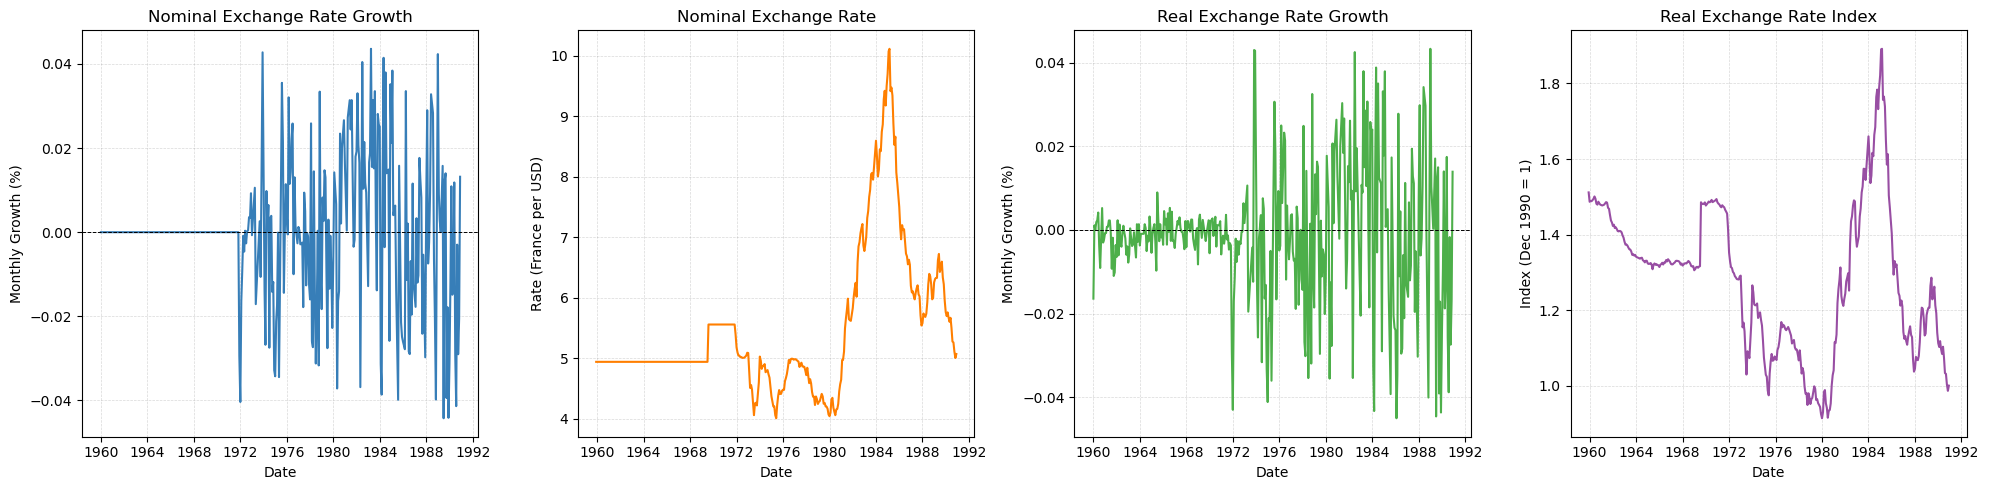

In [19]:
import matplotlib.pyplot as plt
import os

# Define colorblind-friendly colors (from Color Universal Design)
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#984ea3"]  

# Create a horizontal layout with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

# Plot each graph with clear labels, formatting, and gridlines

# 1. Monthly Growth in the Nominal Exchange Rate
axes[0].plot(df["Date"], df["Nominal_Exchange_Growth"], color=colors[0])
axes[0].set_title("Nominal Exchange Rate Growth")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Monthly Growth (%)")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=0.7)
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)  # Faint gridlines

# 2. Level of the Nominal Exchange Rate
axes[1].plot(df["Date"], df["Exchange_Rate_France"], color=colors[1])
axes[1].set_title("Nominal Exchange Rate")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rate (France per USD)")
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)  # Faint gridlines

# 3. Monthly Growth in the Real Exchange Rate
axes[2].plot(df["Date"], df["Real_Exchange_Growth"], color=colors[2])
axes[2].set_title("Real Exchange Rate Growth")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Monthly Growth (%)")
axes[2].axhline(y=0, color="black", linestyle="--", linewidth=0.7)
axes[2].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)  # Faint gridlines

# 4. Real Exchange Rate Index
axes[3].plot(df["Date"], df["Real_Exchange_Index"], color=colors[3])
axes[3].set_title("Real Exchange Rate Index")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Index (Dec 1990 = 1)")
axes[3].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)  # Faint gridlines

# Improve spacing & formatting
plt.tight_layout()

# Save the figure
output_path = "../figures/exchange_rate_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the figure
plt.show()



Plot time series graphs of the monthly indexed value of international reserves for France and the
US from January 1960 until the exit of the US from Bretton Woods.

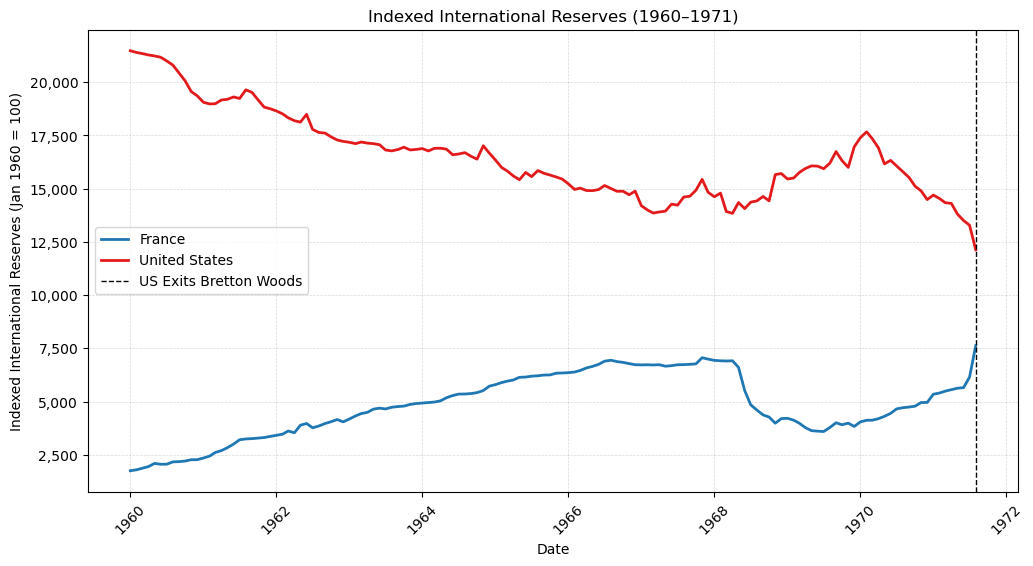

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Filter data from January 1960 to August 1971
df_filtered = df[(df["Date"] >= "1960-01") & (df["Date"] <= "1971-08")]

# Define visually appealing colors
colors = ["#1f78b4", "#e31a1c"]  # Deep blue for France, Deep red for the US

# Create figure
plt.figure(figsize=(12, 6))

# Plot indexed international reserves
plt.plot(df_filtered["Date"], df_filtered["International_Reserves_France"], label="France", color=colors[0], linewidth=2)
plt.plot(df_filtered["Date"], df_filtered["International_Reserves_US"], label="United States", color=colors[1], linewidth=2)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Indexed International Reserves (Jan 1960 = 100)")
plt.title("Indexed International Reserves (1960–1971)")

# Format y-axis with commas for thousands
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Grid, legend, and formatting
plt.axvline(pd.to_datetime("1971-08-01"), color="black", linestyle="--", linewidth=1, label="US Exits Bretton Woods")  # Mark the exit
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
plt.legend()

# Format x-axis dates for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Save the figure
output_path = "../figures/international_reserves_1960_1971.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


The US leaves the Bretton Woods system on 15th August 1971. This is shown by the vertical dashed line.

### 5.2.2. Inflation and Industrial Production Graphs 

**Time series graphs:**

Inflation Graphs: Monthly Inflation & Inflation Difference

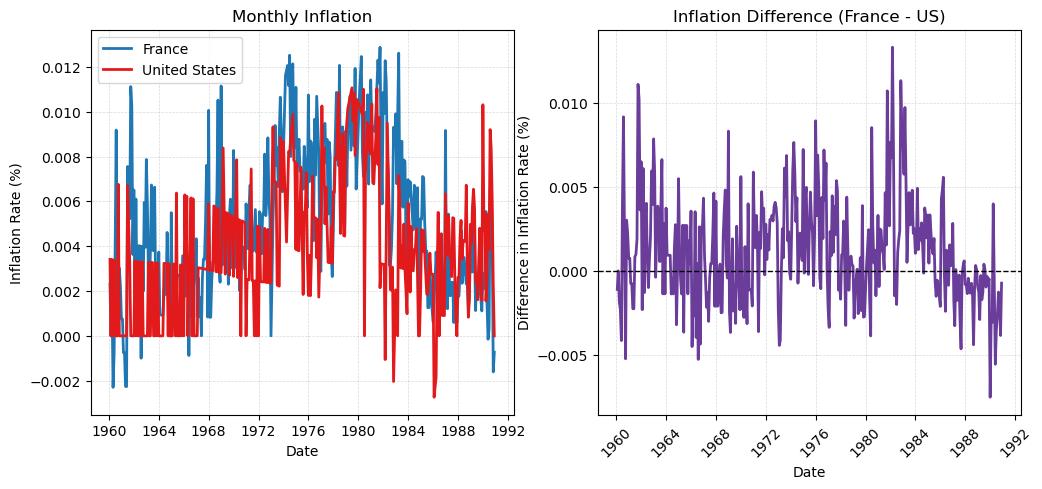

In [21]:
import matplotlib.pyplot as plt

# Define colorblind-friendly colors
colors = ["#1f78b4", "#e31a1c", "#6a3d9a"]  # Blue (France), Red (US), Purple (Difference)

# Create figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# 1. Monthly Inflation (France vs. US)
axes[0].plot(df["Date"], df["France_Inflation"], label="France", color=colors[0], linewidth=2)
axes[0].plot(df["Date"], df["US_Inflation"], label="United States", color=colors[1], linewidth=2)
axes[0].set_title("Monthly Inflation")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate (%)")
axes[0].legend()
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Inflation Difference (France - US)
axes[1].plot(df["Date"], df["France_Inflation"] - df["US_Inflation"], label="France - US", color=colors[2], linewidth=2)
axes[1].set_title("Inflation Difference (France - US)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Difference in Inflation Rate (%)")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/inflation_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



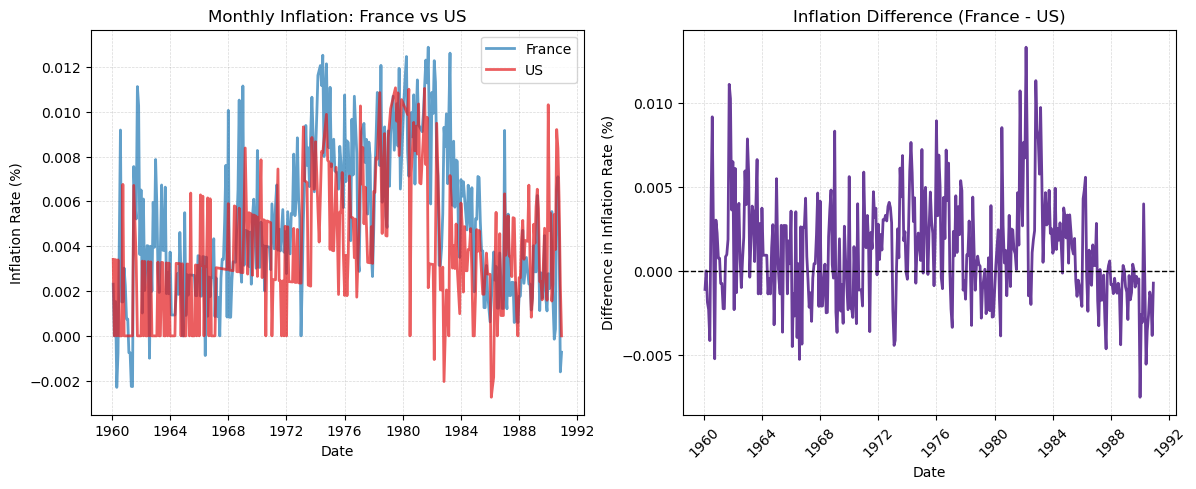

In [22]:
import matplotlib.pyplot as plt

# Define colorblind-friendly colors
colors = ["#1f78b4", "#e31a1c", "#6a3d9a"]  # Blue (France), Red (US), Purple (Difference)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# 1. Combined Inflation (France vs US) with Transparency
axes[0].plot(df["Date"], df["France_Inflation"], color=colors[0], linewidth=2, alpha=0.7, label="France")
axes[0].plot(df["Date"], df["US_Inflation"], color=colors[1], linewidth=2, alpha=0.7, label="US")
axes[0].set_title("Monthly Inflation: France vs US")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate (%)")
axes[0].legend()
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Inflation Difference (France - US)
axes[1].plot(df["Date"], df["France_Inflation"] - df["US_Inflation"], color=colors[2], linewidth=2)
axes[1].set_title("Inflation Difference (France - US)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Difference in Inflation Rate (%)")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)  # Reference line at 0
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/inflation_graphs_combined.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



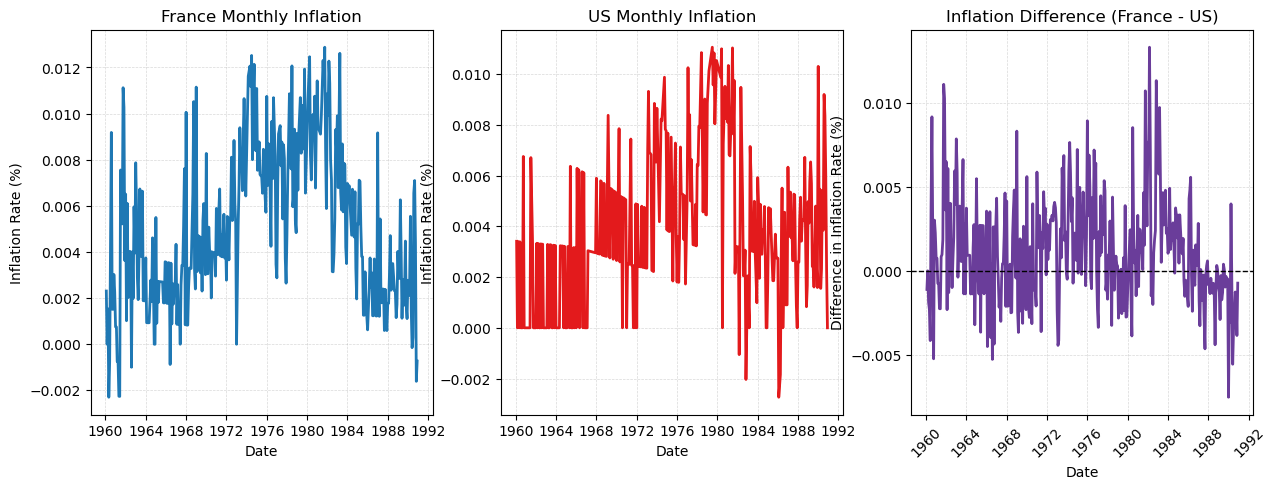

In [23]:
import matplotlib.pyplot as plt

# Define colorblind-friendly colors
colors = ["#1f78b4", "#e31a1c", "#6a3d9a"]  # Blue (France), Red (US), Purple (Difference)

# Create figure with 3 subplots (side by side)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# 1. Monthly Inflation - France
axes[0].plot(df["Date"], df["France_Inflation"], color=colors[0], linewidth=2)
axes[0].set_title("France Monthly Inflation")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate (%)")
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Monthly Inflation - US
axes[1].plot(df["Date"], df["US_Inflation"], color=colors[1], linewidth=2)
axes[1].set_title("US Monthly Inflation")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Inflation Rate (%)")
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 3. Inflation Difference (France - US)
axes[2].plot(df["Date"], df["France_Inflation"] - df["US_Inflation"], color=colors[2], linewidth=2)
axes[2].set_title("Inflation Difference (France - US)")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Difference in Inflation Rate (%)")
axes[2].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[2].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/inflation_graphs_separated.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



Industrial Production:

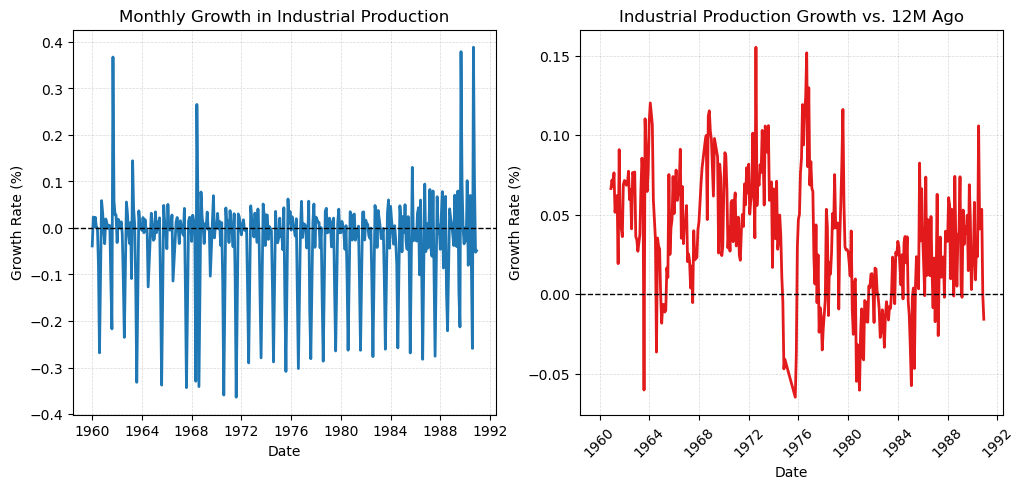

In [24]:
# Create figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# 1. Monthly Growth in Industrial Production
axes[0].plot(df["Date"], df["Industrial_Production_Growth"], color=colors[0], linewidth=2)
axes[0].set_title("Monthly Growth in Industrial Production")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Growth Rate (%)")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Growth in Industrial Production vs. 12 Months Ago
axes[1].plot(df["Date"], df["Industrial_Production_YoY"], color=colors[1], linewidth=2)
axes[1].set_title("Industrial Production Growth vs. 12M Ago")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Growth Rate (%)")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/industrial_production_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()




### 5.2.3. Comparison Statistics & Visualisation

Define Inflation Difference:

In [25]:
# Ensure Inflation Difference is in the dataset
df["Inflation_Difference"] = df["France_Inflation"] - df["US_Inflation"]

Calculations:

In [26]:
# Define periods
before_bw = df[df["Date"] <= "1971-06"]
after_bw = df[df["Date"] >= "1973-03"]

# Variables to analyze
std_vars = [
    "Nominal_Exchange_Growth",
    "Real_Exchange_Growth",
    "France_Inflation",
    "Inflation_Difference",
    "Industrial_Production_YoY"
]

# Compute standard deviations
std_before = before_bw[std_vars].std()
std_after = after_bw[std_vars].std()

# Compute ratio
std_ratio = std_before / std_after

# Create formatted table
std_table = pd.DataFrame({
    "Before Bretton Woods (≤ 06/1971)": std_before,
    "After Bretton Woods (≥ 03/1973)": std_after,
    "Ratio (Before / After)": std_ratio
}).reset_index(names="Variable")

Creating a summary table:

In [27]:
styled_table = std_table.style.background_gradient(
    subset=["Before Bretton Woods (≤ 06/1971)", "After Bretton Woods (≥ 03/1973)", "Ratio (Before / After)"],
    cmap="coolwarm"  # Pastel pink & blue tones
).set_caption("💡 Standard Deviations Before and After Bretton Woods")

display(styled_table)

,Variable,Before Bretton Woods (≤ 06/1971),After Bretton Woods (≥ 03/1973),Ratio (Before / After)
0,Nominal_Exchange_Growth,0.000000,0.020574,0.000000
1,Real_Exchange_Growth,0.003664,0.020529,0.178501
2,France_Inflation,0.002558,0.003436,0.744416
3,Inflation_Difference,0.003196,0.003247,0.984217
4,Industrial_Production_YoY,0.032916,0.041377,0.795517


Creating the chart:

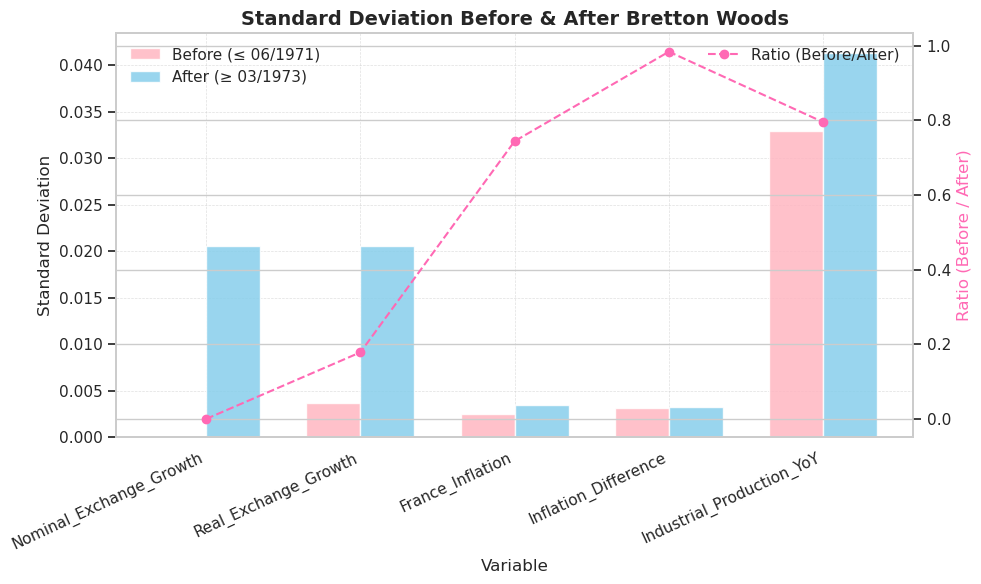

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme & colors
sns.set_theme(style="whitegrid")
colors = ["#FFB6C1", "#87CEEB"]  # Light pink & soft blue
ratio_color = "#FF69B4"  # Hot pink for the ratio line

# Data Preparation
x_labels = std_table["Variable"]
before = std_table["Before Bretton Woods (≤ 06/1971)"]
after = std_table["After Bretton Woods (≥ 03/1973)"]
ratios = std_table["Ratio (Before / After)"]

x = np.arange(len(x_labels))  # Label positions
width = 0.35  # Bar width

# Create figure & axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bars
bars1 = ax.bar(x - width/2, before, width, color=colors[0], label="Before (≤ 06/1971)", alpha=0.85)
bars2 = ax.bar(x + width/2, after, width, color=colors[1], label="After (≥ 03/1973)", alpha=0.85)

# Add ratio line (on secondary y-axis)
ax2 = ax.twinx()
ax2.plot(x, ratios, marker="o", linestyle="--", color=ratio_color, label="Ratio (Before/After)")

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=25, ha="right")
ax.set_xlabel("Variable", fontsize=12)
ax.set_ylabel("Standard Deviation", fontsize=12)
ax2.set_ylabel("Ratio (Before / After)", fontsize=12, color=ratio_color)
ax.set_title("Standard Deviation Before & After Bretton Woods", fontsize=14, fontweight="bold")

# Add gridlines, legend, and layout
ax.grid(True, linestyle="dashed", linewidth=0.5, alpha=0.6)
ax.legend(loc="upper left", frameon=False)
ax2.legend(loc="upper right", frameon=False)
plt.tight_layout()


# Save the chart
plt.savefig("../figures/std_dev_comparison-ratio.png", dpi=300)

# Display the chart 
plt.show()


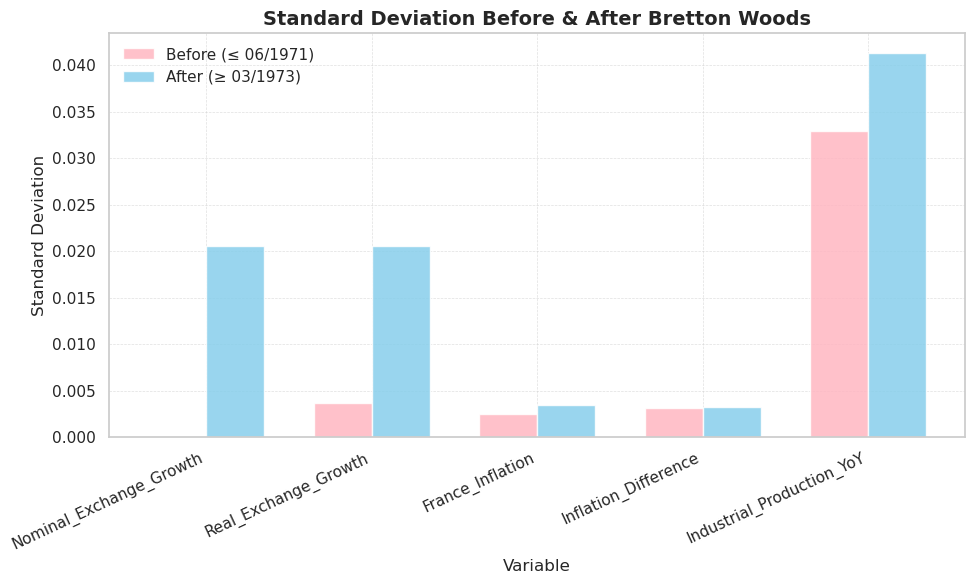

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme & colors
sns.set_theme(style="whitegrid")
colors = ["#FFB6C1", "#87CEEB"]  # Light pink & soft blue

# Data Preparation
x_labels = std_table["Variable"]
before = std_table["Before Bretton Woods (≤ 06/1971)"]
after = std_table["After Bretton Woods (≥ 03/1973)"]

x = np.arange(len(x_labels))  # Label positions
width = 0.35  # Bar width

# Create figure & axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bars
bars1 = ax.bar(x - width/2, before, width, color=colors[0], label="Before (≤ 06/1971)", alpha=0.85)
bars2 = ax.bar(x + width/2, after, width, color=colors[1], label="After (≥ 03/1973)", alpha=0.85)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=25, ha="right")
ax.set_xlabel("Variable", fontsize=12)
ax.set_ylabel("Standard Deviation", fontsize=12)
ax.set_title("Standard Deviation Before & After Bretton Woods", fontsize=14, fontweight="bold")

# Add gridlines and legend
ax.grid(True, linestyle="dashed", linewidth=0.5, alpha=0.6)
ax.legend(loc="upper left", frameon=False)
plt.tight_layout()

# Save the chart
plt.savefig("../figures/std_dev_comparison.png", dpi=300)

# Display the chart
plt.show()


Plot the yearly standard deviation of the variable over time:

/tmp/ipykernel_6553/3356997780.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Year"] = df_filtered["Date"].dt.year  # Extract year


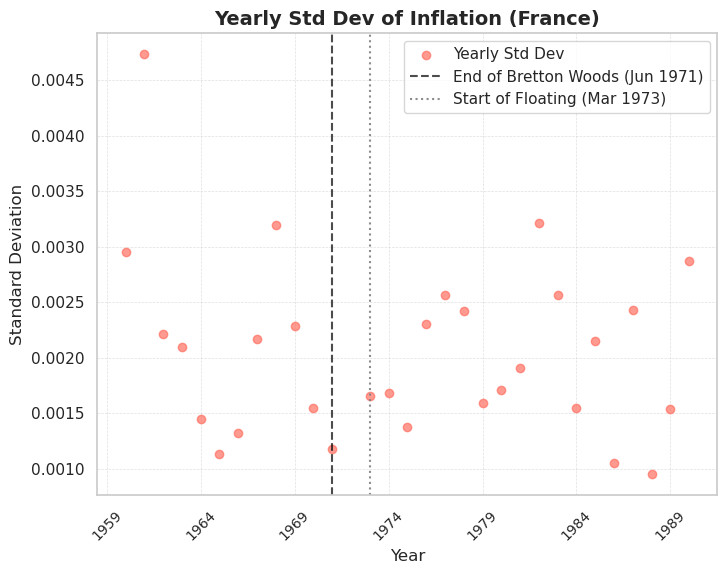

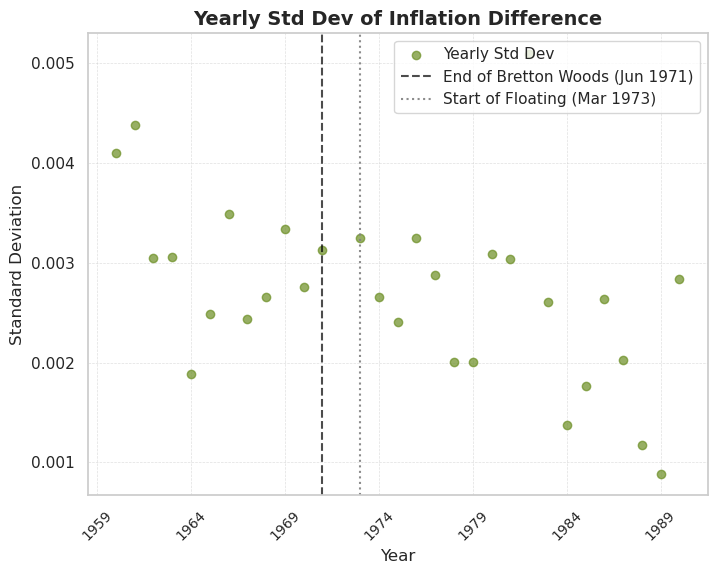

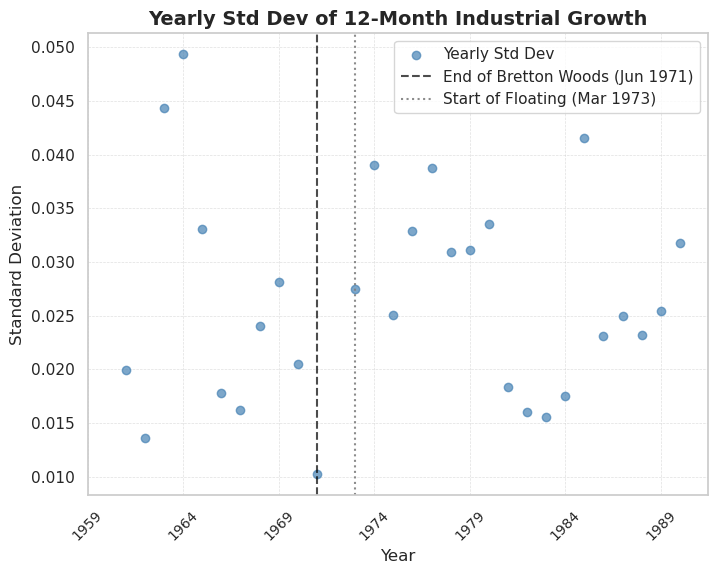

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure "figures" folder exists
os.makedirs("figures", exist_ok=True)

# Define pre/post Bretton Woods periods
pre_bretton_woods_end = "1971-06"
post_bretton_woods_start = "1973-03"

# Filter out data from 07/1971 - 02/1973
df_filtered = df[(df["Date"] <= pre_bretton_woods_end) | (df["Date"] >= post_bretton_woods_start)]
df_filtered["Year"] = df_filtered["Date"].dt.year  # Extract year

# Compute yearly standard deviations
yearly_std = df_filtered.groupby("Year")[["France_Inflation", "Inflation_Difference", "Industrial_Production_YoY"]].std()

# Set up colors & x-axis ticks
colors = {"France_Inflation": "#FF6F61", "Inflation_Difference": "#6B8E23", "Industrial_Production_YoY": "#4682B4"}
x_ticks = np.arange(yearly_std.index.min(), yearly_std.index.max() + 1, 5)

# Function to plot and save each graph
def plot_scatter(variable, title, filename, color):
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")

    # Scatter plot
    plt.scatter(yearly_std.index, yearly_std[variable], color=color, alpha=0.7, label="Yearly Std Dev")
    
    # Add vertical lines for Bretton Woods transition
    plt.axvline(x=1971, color="black", linestyle="dashed", alpha=0.7, label="End of Bretton Woods (Jun 1971)")
    plt.axvline(x=1973, color="gray", linestyle="dotted", alpha=0.9, label="Start of Floating (Mar 1973)")

    # Formatting
    plt.title(title, fontsize=14, fontweight="bold")
    plt.ylabel("Standard Deviation", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.xticks(x_ticks, rotation=45, fontsize=10)  # Explicitly set numbered x-axis labels
    plt.grid(True, linestyle="dashed", linewidth=0.5, alpha=0.6)
    plt.legend()

    # Save figure
    plt.savefig(f"../figures/{filename}.png", dpi=300)
    plt.show()

# Generate & save all three plots
plot_scatter("France_Inflation", "Yearly Std Dev of Inflation (France)", "yearly_std_dev_inflation_france", colors["France_Inflation"])
plot_scatter("Inflation_Difference", "Yearly Std Dev of Inflation Difference", "yearly_std_dev_inflation_diff", colors["Inflation_Difference"])
plot_scatter("Industrial_Production_YoY", "Yearly Std Dev of 12-Month Industrial Growth", "yearly_std_dev_industrial", colors["Industrial_Production_YoY"])


### 5.2.4. Regression Analysis

Calculating standard deviation

In [59]:
import pandas as pd
import numpy as np

# Remove rows from 1959
df = df[df["Date"].dt.year > 1959]

# Extract year and half-year indicator
df["Year"] = df["Date"].dt.year
df["Half"] = np.where(df["Date"].dt.month <= 6, "H1", "H2")

# Group by year and half-year and compute standard deviations
six_monthly_std_dev = df.groupby(["Year", "Half"]).agg({
    "Real_Exchange_Growth": "std",
    "Inflation_Difference": "std",
    "Industrial_Production_Growth": "std"
}).reset_index()

# Rename columns for clarity
six_monthly_std_dev.rename(columns={
    "Real_Exchange_Growth": "Real_Exchange_Growth_Std",
    "Inflation_Difference": "Inflation_Difference_Std",
    "Industrial_Production_Growth": "Industrial_Production_Growth_Std"
}, inplace=True)

# Display results
print(six_monthly_std_dev)

# Save the DataFrame as a CSV file
six_monthly_std_dev.to_csv("../figures/six_monthly_std_dev.csv", index=True)

    Year Half  Real_Exchange_Growth_Std  Inflation_Difference_Std  \
0   1960   H1                  0.007601                  0.001540   
1   1960   H2                  0.004612                  0.004640   
2   1961   H1                  0.001348                  0.001346   
3   1961   H2                  0.004525                  0.004692   
4   1962   H1                  0.003699                  0.003717   
5   1962   H2                  0.002511                  0.002523   
6   1963   H1                  0.002870                  0.002892   
7   1963   H2                  0.003150                  0.003166   
8   1964   H1                  0.001619                  0.001625   
9   1964   H2                  0.002844                  0.002089   
10  1965   H1                  0.004169                  0.003217   
11  1965   H2                  0.004223                  0.001663   
12  1966   H1                  0.003609                  0.003617   
13  1966   H2                  0.0

In [56]:
# Manual verification for a specific 6-month period (example: Jan-Jun 1970)
manually_checked = df[(df["Year"] == 1970) & (df["Half"] == "H1")][["Real_Exchange_Growth", "Inflation_Difference", "Industrial_Production_YoY"]].std()
print("\nManual Calculation for Jan-Jun 1970:")
print(manually_checked)



Manual Calculation for Jan-Jun 1970:
Real_Exchange_Growth         0.003211
Inflation_Difference         0.003232
Industrial_Production_YoY    0.023883
dtype: float64


**remember to do the manual check for Jan-June 1970.

**Regression analysis**

In [47]:
import statsmodels.api as sm

# Define the independent variable (real exchange rate standard deviation)
X = six_monthly_std_dev["Real_Exchange_Growth_Std"]
X = sm.add_constant(X)  # Adds an intercept to the model

# Regression 1: Inflation difference standard deviation
y1 = six_monthly_std_dev["Inflation_Difference_Std"]
model1 = sm.OLS(y1, X).fit()
print("Regression Results: Inflation Difference Standard Deviation")
print(model1.summary())

# Regression 2: 12-monthly industrial production growth standard deviation
y2 = six_monthly_std_dev["Industrial_Production_Growth_Std"]
model2 = sm.OLS(y2, X).fit()
print("\nRegression Results: Industrial Production Growth Standard Deviation")
print(model2.summary())


Regression Results: Inflation Difference Standard Deviation
                               OLS Regression Results                               
Dep. Variable:     Inflation_Difference_Std   R-squared:                       0.040
Model:                                  OLS   Adj. R-squared:                  0.024
Method:                       Least Squares   F-statistic:                     2.520
Date:                      Fri, 14 Mar 2025   Prob (F-statistic):              0.118
Time:                              19:46:04   Log-Likelihood:                 332.61
No. Observations:                        62   AIC:                            -661.2
Df Residuals:                            60   BIC:                            -657.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.97

**Side by side graphs:**

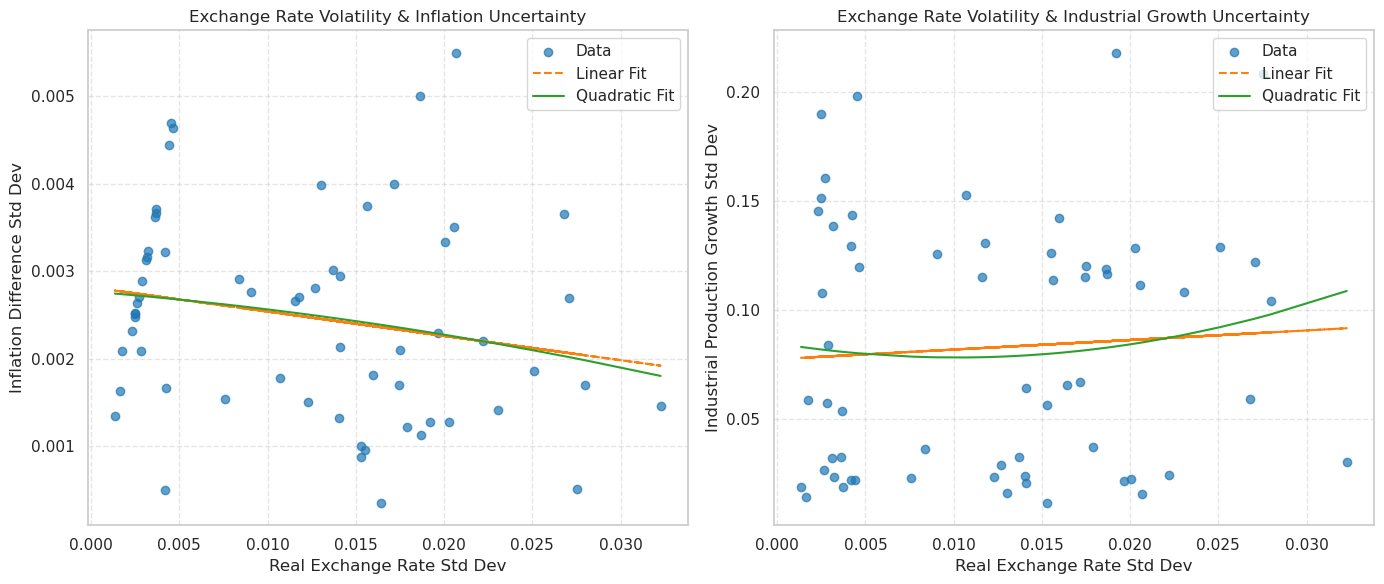

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Define independent variable
X = six_monthly_std_dev["Real_Exchange_Growth_Std"]

# Define dependent variables
y1 = six_monthly_std_dev["Inflation_Difference_Std"]
y2 = six_monthly_std_dev["Industrial_Production_Growth_Std"]

# Create figure with 2 side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Define colors
scatter_color = "#1f77b4"  # Blue for scatter points
linear_color = "#ff7f0e"   # Orange for linear fit
quadratic_color = "#2ca02c"  # Green for quadratic fit

# Function to add regression lines
def add_regression_lines(ax, X, y):
    # Scatter plot
    ax.scatter(X, y, color=scatter_color, alpha=0.7, label="Data")

    # Linear regression
    X_lin = sm.add_constant(X)
    lin_model = sm.OLS(y, X_lin).fit()
    ax.plot(X, lin_model.predict(X_lin), color=linear_color, linestyle="--", label="Linear Fit")

    # Quadratic regression
    X_quad = np.column_stack((X, X**2))
    X_quad = sm.add_constant(X_quad)
    quad_model = sm.OLS(y, X_quad).fit()
    X_sorted = np.sort(X)
    quad_pred = quad_model.predict(sm.add_constant(np.column_stack((X_sorted, X_sorted**2))))
    ax.plot(X_sorted, quad_pred, color=quadratic_color, linestyle="-", label="Quadratic Fit")

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

# Plot Inflation Difference vs. Real Exchange Rate Std Dev
add_regression_lines(axes[0], X, y1)
axes[0].set_title("Exchange Rate Volatility & Inflation Uncertainty")
axes[0].set_xlabel("Real Exchange Rate Std Dev")
axes[0].set_ylabel("Inflation Difference Std Dev")

# Plot Industrial Production Growth Std Dev vs. Real Exchange Rate Std Dev
add_regression_lines(axes[1], X, y2)
axes[1].set_title("Exchange Rate Volatility & Industrial Growth Uncertainty")
axes[1].set_xlabel("Real Exchange Rate Std Dev")
axes[1].set_ylabel("Industrial Production Growth Std Dev")

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("../figures/exchange_rate_volatility_vs_uncertainty.png", dpi=300, bbox_inches="tight")


